In [121]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, Lasso
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor
import patsy

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS

In [122]:
df = pd.read_csv('data/job_training.csv').drop(columns=['Unnamed: 0'])

controls = list(df.columns[1:-2])
treatment = ['treated']
target = ['re18']

In [128]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,treated,age,educ,black,hisp,married,nodegree,urban,fsize,re14,re18
treated,1.00,-0.10,-0.07,0.26,0.01,-0.15,0.11,0.00,-0.10,-0.13,-0.11
age,-0.10,1.00,-0.12,-0.07,-0.01,0.43,0.04,0.00,0.28,0.34,0.16
educ,-0.07,-0.12,1.00,-0.17,-0.18,0.03,-0.73,-0.01,0.02,0.18,0.19
black,0.26,-0.07,-0.17,1.00,-0.10,-0.13,0.19,0.01,-0.08,-0.15,-0.14
hisp,0.01,-0.01,-0.18,-0.10,1.00,-0.00,0.14,-0.00,-0.00,-0.05,-0.05
married,-0.15,0.43,0.03,-0.13,-0.00,1.00,-0.10,-0.00,0.66,0.39,0.27
nodegree,0.11,0.04,-0.73,0.19,0.14,-0.10,1.00,0.01,-0.07,-0.21,-0.19
urban,0.00,0.00,-0.01,0.01,-0.00,-0.00,0.01,1.00,0.00,-0.00,-0.00
fsize,-0.10,0.28,0.02,-0.08,-0.00,0.66,-0.07,0.00,1.00,0.26,0.19
re14,-0.13,0.34,0.18,-0.15,-0.05,0.39,-0.21,-0.00,0.26,1.00,0.70


In [72]:
df.head()

,treated,age,educ,black,hisp,married,nodegree,urban,fsize,re14,re18
0,0,42,16,0,0,1,0,1,2,0.000000,100.485405
1,0,20,13,0,0,0,0,1,1,3317.467773,4793.745117
2,0,37,12,0,0,1,0,1,4,22781.855469,25564.669922
3,0,48,12,0,0,1,0,1,3,20839.355469,20550.744141
4,0,51,12,0,0,1,0,0,2,21575.177734,22783.587891


In [104]:
df['black'].value_counts()

black
0    16826
1     2378
Name: count, dtype: int64

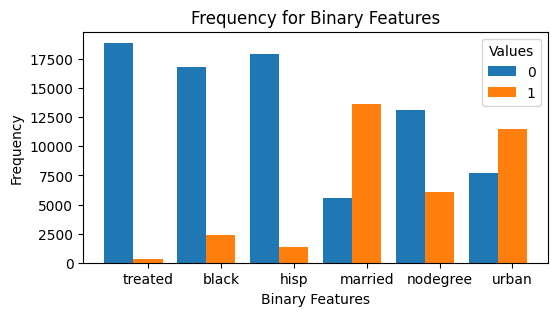

In [120]:
# df['re18'].apply(lambda x: np.log10(1+x)).plot(kind='hist', title='real income 2018 (log10(x+1))', bins=20)
# plt.plot()
binary_features = ['treated','black','hisp','married','nodegree','urban']
fig, ax = plt.subplots(figsize=(6, 3))

x = np.arange(len(binary_features))
y1 = [df[c].value_counts()[0] for c in binary_features]
y2 = [df[c].value_counts()[1] for c in binary_features]

# create data


width = 0.40
  
# plot data in grouped manner of bar type
ax.bar(x-0.2, y1, width)
ax.bar(x+0.2, y2, width)

ax.set_xticks([pos + 0.5 * width for pos in x])
ax.set_xticklabels(binary_features)
ax.set_xlabel('Binary Features')
ax.set_ylabel('Frequency')
ax.legend(title='Values', labels=['0', '1'])
plt.title('Frequency for Binary Features')

plt.show()

# Basic Regression

In [3]:
X = df[controls+treatment]
y = df[target]
X = sm.add_constant(X)
sm.OLS(y,X).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,3356.0594,612.011,5.484,0.000,2156.464,4555.655
age,80.5235,7.564,10.646,0.000,65.698,95.349
educ,529.3813,38.347,13.805,0.000,454.219,604.544
black,-2127.2936,239.126,-8.896,0.000,-2596.001,-1658.586
hisp,-836.1816,301.189,-2.776,0.006,-1426.538,-245.826
married,4879.3821,232.751,20.964,0.000,4423.171,5335.593
nodegree,-1272.2283,236.430,-5.381,0.000,-1735.652,-808.805
urban,51.7305,150.624,0.343,0.731,-243.506,346.967
fsize,106.4168,64.927,1.639,0.101,-20.846,233.679
treated,-3139.1735,626.165,-5.013,0.000,-4366.513,-1911.834


# Approach 1: Basic DiD (TWFE)
$$
Y_{it} = \beta + \delta p_t + \gamma G_i + \tau D_{it} + \epsilon_{it}
$$

Equivalently,

$$
Y_{it} = \beta + \delta p_t + \gamma G_i + \tau p_t\times G_i + \epsilon_{it}
$$

For this, we must turn the panel dataframe into DiD-style dataframe.

In [129]:
def generate_basic_did(df):
    # create 2014 data with period:=0
    df_did_before = df[['re14','treated']].assign(period=0)\
            .rename(columns={'re14':'realIncome','treated':'tgroup'})[['tgroup','period','realIncome']]
    
    # create 2018 data with period:=1
    df_did_after = df[['re18','treated']]\
            .assign(period=1).rename(columns={'re18':'realIncome','treated':'tgroup'})[['tgroup','period','realIncome']]

    # combine dataframes and create the treated variable (D_it)
    df_did = pd.concat([df_did_before, df_did_after])
    df_did['treated'] = df_did['tgroup']*df_did['period']
    return df_did[['tgroup','period','treated','realIncome']].copy()



In [130]:
df_did = generate_basic_did(df)

df_did.sample(5)

,tgroup,period,treated,realIncome
6387,0,1,0,24212.550781
2237,0,1,0,659.066040
9135,0,1,0,8522.048828
2258,0,0,0,14028.967773
10083,0,0,0,3976.306396


In [6]:
X = df_did[['tgroup','period','treated']]
y = df_did['realIncome']
X = sm.add_constant(X)
sm.OLS(y,X).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,1.412e+04,76.347,185.008,0.000,1.4e+04,1.43e+04
tgroup,-1.106e+04,613.918,-18.013,0.000,-1.23e+04,-9855.413
period,1385.8687,107.971,12.836,0.000,1174.243,1597.495
treated,1524.3851,868.211,1.756,0.079,-177.330,3226.100


# Approach 2: Using `patsy` formulas for complex models

We include extra covariates to control for time-invariant characteristics.

In [7]:
def generate_controls_did(df, controls=['age','educ','black','hisp','married','nodegree','urban','fsize']):
    df_did_before = df[['re14','treated']+controls].assign(period=0).rename(columns={'re14':'realIncome','treated':'tgroup'})
    df_did_after = df[['re18','treated']+controls].assign(period=1).rename(columns={'re18':'realIncome','treated':'tgroup'})
    df_did = pd.concat([df_did_before,df_did_after])
    df_did['treated'] = df_did['tgroup']*df_did['period']
    return df_did[controls + ['tgroup','period','treated','realIncome']].copy()

df_controls_did = generate_controls_did(df)

df_controls_did.head()

,age,educ,black,hisp,married,nodegree,urban,fsize,tgroup,period,treated,realIncome
0,42,16,0,0,1,0,1,2,0,0,0,0.000000
1,20,13,0,0,0,0,1,1,0,0,0,3317.467773
2,37,12,0,0,1,0,1,4,0,0,0,22781.855469
3,48,12,0,0,1,0,1,3,0,0,0,20839.355469
4,51,12,0,0,1,0,0,2,0,0,0,21575.177734


In [8]:
# This should be the same as the previous simple DiD

y, X = patsy.dmatrices("realIncome ~ period + tgroup + period:tgroup", df_controls_did)
sm.OLS(y,X).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.412e+04,76.347,185.008,0.000,1.4e+04,1.43e+04
period,1385.8687,107.971,12.836,0.000,1174.243,1597.495
tgroup,-1.106e+04,613.918,-18.013,0.000,-1.23e+04,-9855.413
period:tgroup,1524.3851,868.211,1.756,0.079,-177.330,3226.100


In [9]:
y, X = patsy.dmatrices("realIncome ~ period + tgroup + tgroup:period + period:(age + educ + black + hisp + married + nodegree + urban + fsize)", df_controls_did)
sm.OLS(y,X).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.412e+04,74.049,190.749,0.000,1.4e+04,1.43e+04
period,-1.077e+04,613.276,-17.559,0.000,-1.2e+04,-9566.709
tgroup,-1.106e+04,595.441,-18.572,0.000,-1.22e+04,-9891.628
tgroup:period,7919.5337,861.693,9.191,0.000,6230.592,9608.475
period:age,80.5235,7.524,10.703,0.000,65.777,95.270
period:educ,529.3813,38.145,13.878,0.000,454.617,604.146
period:black,-2127.2936,237.867,-8.943,0.000,-2593.519,-1661.068
period:hisp,-836.1816,299.603,-2.791,0.005,-1423.411,-248.952
period:married,4879.3821,231.525,21.075,0.000,4425.587,5333.178
period:nodegree,-1272.2283,235.185,-5.409,0.000,-1733.198,-811.259


# Approach 3: using entropy balancing

In [10]:
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.3.1'

# These will let us use R packages:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

In [11]:
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('ebal')
utils.install_packages('WeightIt')

R[write to console]: Installing package into 'C:/Users/Kai/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.3/ebal_0.1-8.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 45353 bytes (44 KB)

R[write to console]: downloaded 44 KB




package 'ebal' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kai\AppData\Local\Temp\RtmpET29H0\downloaded_packages


R[write to console]: Installing package into 'C:/Users/Kai/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.3/WeightIt_0.14.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 1013453 bytes (989 KB)

R[write to console]: downloaded 989 KB




package 'WeightIt' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kai\AppData\Local\Temp\RtmpET29H0\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x000001E04ADF9FD0> [0]

In [12]:
ebal = importr("ebal")

In [13]:
df_controls_did.head()

,age,educ,black,hisp,married,nodegree,urban,fsize,tgroup,period,treated,realIncome
0,42,16,0,0,1,0,1,2,0,0,0,0.000000
1,20,13,0,0,0,0,1,1,0,0,0,3317.467773
2,37,12,0,0,1,0,1,4,0,0,0,22781.855469
3,48,12,0,0,1,0,1,3,0,0,0,20839.355469
4,51,12,0,0,1,0,0,2,0,0,0,21575.177734


In [14]:
print('Get covariates matrix...')
X = df_controls_did.drop(columns = ['treated', 'realIncome', 'period', 'tgroup'], axis=1)

print('Generate entropy-balanced weights... (ignore the following warning)')
out = ebal.ebalance(Treatment=df_controls_did['treated'], X = X)
weights = out[2]

print(f'weights.shape: {weights.shape}')

print('Create weights vector for all rows...')
df_controls_did['weights'] = 1
df_controls_did.loc[df_controls_did['treated']==0,'weights'] = weights

print('Done!')

Get covariates matrix...
Generate entropy-balanced weights... (ignore the following warning)


C:\Users\Kai\anaconda3\envs\uni\Lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Converged within tolerance 
weights.shape: (38111,)
Create weights vector for all rows...
Done!


In [15]:
print('Basic entropy-balanced DiD')
y, X = patsy.dmatrices("realIncome ~ period + tgroup + period:tgroup", df_controls_did)
WLS(y,X, weights=df_controls_did['weights']).fit().summary().tables[1]

Basic entropy-balanced DiD


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6232.6759,78.988,78.906,0.000,6077.857,6387.495
period,2433.5451,111.706,21.785,0.000,2214.598,2652.492
tgroup,-3703.3156,197.110,-18.788,0.000,-4089.656,-3316.975
period:tgroup,1013.4466,218.949,4.629,0.000,584.301,1442.593


In [16]:
print('Entropy-balanced DiD with extra controls')
y, X = patsy.dmatrices("realIncome ~ period + tgroup + tgroup:period + period:(age + educ + black + hisp + married + nodegree + urban + fsize)", df_controls_did)
WLS(y,X, weights=df_controls_did['weights']).fit().summary().tables[1]

Entropy-balanced DiD with extra controls


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6232.6759,76.510,81.462,0.000,6082.714,6382.638
period,-3342.8269,476.950,-7.009,0.000,-4277.662,-2407.992
tgroup,-3703.3156,190.927,-19.397,0.000,-4077.537,-3329.094
tgroup:period,1115.0661,212.096,5.257,0.000,699.352,1530.780
period:age,106.2277,6.313,16.828,0.000,93.855,118.601
period:educ,486.8453,29.324,16.602,0.000,429.369,544.321
period:black,-1497.5718,140.865,-10.631,0.000,-1773.671,-1221.473
period:hisp,-230.8790,193.909,-1.191,0.234,-610.946,149.188
period:married,1785.5618,198.804,8.982,0.000,1395.901,2175.222
period:nodegree,-986.5263,132.698,-7.434,0.000,-1246.617,-726.436


# Approach 4: First Differencing

Formulation:

$$
\Delta Y_i = \Delta\gamma + \tau\Delta D_i + \Delta \epsilon_i
$$

In [17]:
DY = df['re18'] - df['re14']
Dgamma = pd.Series(np.ones(df.index.shape), name='DGamma') # it's a constant bc it just represents the time period change, any nonzero constant value will work here
DD = df['treated'] # if they were untreated then treated, represent this as 1. If they were untreated then untreated, represent as 0. This is conveniently the same as df['treated']

X = pd.concat([Dgamma, DD], axis=1).astype(float)
y = DY

In [18]:
sm.OLS(y, X).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
DGamma,1385.8687,59.530,23.280,0.000,1269.184,1502.553
treated,1524.3851,478.692,3.184,0.001,586.107,2462.664


In [19]:
# ...alternatively

y_p, X_p = patsy.dmatrices("deltaY ~ 1 + treated", df.assign(deltaY=df['re18']-df['re14']))
sm.OLS(y_p, X_p).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1385.8687,59.530,23.280,0.000,1269.184,1502.553
treated,1524.3851,478.692,3.184,0.001,586.107,2462.664


# Approach 5: Fixed Effects

Formulation:

Estimate the pooled sample mean of Y and D by
$$
\bar{Y} = \frac{1}{NT}\sum\limits_{i,t}Y_{it}
$$

Estimate the sample mean over time and over unit of Y and D by$$
\bar{Y}_{i\cdot} = \frac{1}{T}\sum\limits_{t=1}^TY_{it}
$$
$$
\bar{Y}_{\cdot t} = \frac{1}{N}\sum\limits_{i=1}^NY_{it}
$$

Finally
$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_{i\cdot} - \bar{Y}_{\cdot t} + \bar{Y}
$$

Do the same for the treatment variable and estimate:

$$
\ddot{Y}_{it} = \tau \ddot{D}_{it} + \epsilon_{it}
$$

In [20]:
df_fe = df_did.rename(columns={'treated':'D', 'realIncome':'Y'}).copy()
df_fe.head()

,tgroup,period,D,Y
0,0,0,0,0.000000
1,0,0,0,3317.467773
2,0,0,0,22781.855469
3,0,0,0,20839.355469
4,0,0,0,21575.177734


In [21]:
mean_individual_Y = df_fe.groupby(df_fe.index)['Y'].transform('mean')
mean_time_period_Y = df_fe.groupby('period')['Y'].transform('mean')

mean_individual_D = df_fe.groupby(df_fe.index)['D'].transform('mean')
mean_time_period_D = df_fe.groupby('period')['D'].transform('mean')

In [22]:
df_fe['Y..'] = df_fe['Y'] - mean_individual_Y - mean_time_period_Y + df_fe['Y'].mean()
df_fe['D..'] = df_fe['D'] - mean_individual_D - mean_time_period_D + df_fe['D'].mean()

In [23]:
sm.OLS(df_fe['Y..'], df_fe['D..']).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
D..,1524.3851,338.473,4.504,0.000,860.969,2187.801


# Approach 6: HTE

## 6.1: Interaction Regressions

We start with the model:

$$
Y_i = \tau D_i + X_i\beta + D_i\cdot(X_i-\bar{X})\eta + \epsilon_i
$$

In [24]:
df_ir = df.copy()
controls_demeaned = [c + '_demeaned' for c in controls]
print(control_pairs:=list(zip(controls,controls_demeaned)))

[('age', 'age_demeaned'), ('educ', 'educ_demeaned'), ('black', 'black_demeaned'), ('hisp', 'hisp_demeaned'), ('married', 'married_demeaned'), ('nodegree', 'nodegree_demeaned'), ('urban', 'urban_demeaned'), ('fsize', 'fsize_demeaned')]


In [25]:
for c, c_demeaned in control_pairs:
    df_ir[c_demeaned] = df_ir[c] - df_ir[c].mean()

In [26]:
formula = 're18 ~ treated' + ' + ' + ' + '.join(controls) + ' + ' 'treated:(' + ' + '.join(controls_demeaned) + ')'
print('='*5 + ' FORMULA ' + '='*5 + '\n\n' + formula + '\n\n' + '='*5 + '=========' + '='*5)

y, X = patsy.dmatrices(formula, df_ir)
sm.OLS(y, X).fit().summary().tables[1]

===== FORMULA =====

re18 ~ treated + age + educ + black + hisp + married + nodegree + urban + fsize + treated:(age_demeaned + educ_demeaned + black_demeaned + hisp_demeaned + married_demeaned + nodegree_demeaned + urban_demeaned + fsize_demeaned)



,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3346.4228,614.929,5.442,0.000,2141.108,4551.737
treated,-6554.6492,1879.410,-3.488,0.000,-1.02e+04,-2870.841
age,80.3953,7.591,10.591,0.000,65.517,95.274
educ,527.5791,38.537,13.690,0.000,452.044,603.114
black,-2139.9258,241.813,-8.849,0.000,-2613.901,-1665.950
hisp,-832.7564,303.894,-2.740,0.006,-1428.415,-237.098
married,4925.9391,233.923,21.058,0.000,4467.430,5384.448
nodegree,-1298.3449,238.610,-5.441,0.000,-1766.042,-830.647
urban,83.9261,151.775,0.553,0.580,-213.566,381.418
fsize,103.3361,65.031,1.589,0.112,-24.131,230.803


## 6.2: Causal Trees

In [27]:
import sys
sys.path.append('../CTL')

import CTL
from CTL.causal_tree_learn import CausalTree

In [28]:
from sklearn.model_selection import train_test_split
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [39]:
y = (df['re18']).values
treatment = df['treated'].values

x = df.drop(['re18', 'treated'], axis=1).values
columns = df.drop(['re18', 'treated'], axis=1).columns

y[y == 0] = -1

# We don't need to translate our treatment
# treatment[treatment == 1] = 0
# treatment[treatment == 2] = 1

np.random.seed(0)

x_train, x_test, y_train, y_test, treat_train, treat_test = train_test_split(x, y, treatment,
                                                                             test_size=0.5, random_state=42)

# regular CTL
ctl = CausalTree(magnitude=False)
ctl.fit(x_train, y_train, treat_train)
ctl.prune()
ctl_predict = ctl.predict(x_test)

# honest CTL (CT-HL)
cthl = CausalTree(honest=True)
cthl.fit(x_train, y_train, treat_train)
cthl.prune()
cthl_predict = cthl.predict(x_test)

# val honest CTL (CT-HV)
cthv = CausalTree(val_honest=True)
cthv.fit(x_train, y_train, treat_train)
cthv.prune()
cthv_predict = cthv.predict(x_test)

# adaptive CT (Athey and Imbens, PNAS 2016)
ct_adaptive = CausalTree(weight=0.0, split_size=0.0)
ct_adaptive.fit(x_train, y_train, treat_train)
ct_adaptive.prune()
ct_adaptive_predict = cthv.predict(x_test)

# honest CT (Athey and Imbens, PNAS 2016)
ct_honest = CausalTree(honest=True, weight=0.0, split_size=0.0)
ct_honest.fit(x_train, y_train, treat_train)
ct_honest.prune()
ct_honest_predict = ct_honest.predict(x_test)

ct_adaptive.plot_tree(features=columns, filename="output/bin_tree_adaptive", show_effect=True)
ct_honest.plot_tree(features=columns, filename="output/bin_tree_honest", show_effect=True)
ctl.plot_tree(features=columns, filename="output/bin_tree", show_effect=True)
cthl.plot_tree(features=columns, filename="output/bin_tree_honest_learn", show_effect=True)
cthv.plot_tree(features=columns, filename="output/bin_tree_honest_validation", show_effect=True)

C:\Users\Kai\Coding\UNSW\ECON3210\econ3210\../CTL\CTL\causal_tree\ctl\adaptive.py:148: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  fb_p_val = get_pval(y2, t2)
C:\Users\Kai\Coding\UNSW\ECON3210\econ3210\../CTL\CTL\causal_tree\ctl\adaptive.py:147: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tb_p_val = get_pval(y1, t1)


In [57]:
ct_test = CausalTree(honest=True, split_size=0.0)
ct_test.fit(x_train, y_train, treat_train)
ct_test.prune(alpha=0.1)
ct_test_predict = ct_test.predict(x_test)

ct_test.plot_tree(features=columns, filename="output/cth_alpha_01", show_effect=True)